In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Input, Dropout, BatchNormalization,  concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# fix random seed for reproducibility
np.random.seed(7)
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras import regularizers
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Model

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Mounting google drive so as to load dataset from google drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Tensorboard dashboard
# Open the link generated here for TensorBoard Dashboard

!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://03cda8bf.ngrok.io


In [0]:
# plot functions for loss and auc

%matplotlib notebook
%matplotlib inline

def plt_dynamic_loss(x, t_loss , cv_loss ):
  
  sns.set()
  
  fig , ax1 = plt.subplots()
  ax1.plot(x, cv_loss, 'b', label="Validation Loss")
  ax1.plot(x, t_loss, 'r', label="Train Loss")
  
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('Categorical CrossEntropyloss')
  
  
 
  
  plt.legend()
  plt.grid()
  plt.show()
  

def plt_dynamic_auc(x, t_auc , cv_auc):
  
  sns.set()
  
  fig ,ax1 = plt.subplots()
  ax1.plot(x, cv_auc, 'b', label="Validation auc")
  ax1.plot(x, t_auc, 'r', label="Train auc")
  
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('AUC ROC')
  
  plt.legend()
  plt.grid()
  plt.show()

In [6]:
# This is the preprocesses dataset of DonorsChoose dataset,
# Here we performed text cleaning, stopword removal, amputing missing values on text and some preprocessing on categorical features

dataset_path = '/content/gdrive/My Drive/AppliedAI Dataset/DonorsChoose_Lstm/preprocessed_data.csv'

data = pd.read_csv(dataset_path)

data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [7]:
print(data.columns)
print(data.shape)


Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')
(109248, 9)


In [8]:
# Taking a sample of 60000 points from project data for analysis

X = data

y = X['project_is_approved'].values

X.drop(['project_is_approved'], axis=1, inplace=True)

print(X.shape ,y.shape)


(109248, 8) (109248,)


### Splitting data int train, test and cv

In [9]:
from sklearn.model_selection import train_test_split
x_train, X_test, y_train, Y_test = train_test_split(X, y, test_size=0.20, stratify=y , random_state =7 )
X_train , X_cv  , Y_train , Y_cv  =  train_test_split(x_train, y_train, test_size=0.20, stratify=y_train , random_state =7 )

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_cv.shape,Y_cv.shape)


(69918, 8) (69918,)
(21850, 8) (21850,)
(17480, 8) (17480,)


In [0]:
# Defining Custom ROC-AUC Metrics
from sklearn.metrics import roc_auc_score

def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

### Integer Encoding of text data

In [11]:
from keras.preprocessing.text import Tokenizer
# Encodes from index 1 to max_vocabulary_words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['essay'])

X_train['IntegerEncoding_1']  = tokenizer.texts_to_sequences(X_train['essay'].values)
X_cv['IntegerEncoding_1']     = tokenizer.texts_to_sequences(X_cv['essay'].values)
X_test['IntegerEncoding_1']   = tokenizer.texts_to_sequences(X_test['essay'].values)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [12]:
X_train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,IntegerEncoding_1
20846,la,ms,grades_prek_2,0,math_science,mathematics,my school small population big heart i want in...,376.76,"[4, 3, 81, 226, 406, 678, 2, 34, 470, 1, 19, 5..."
81132,mi,ms,grades_prek_2,6,literacy_language math_science,literature_writing mathematics,a typical day classroom busy we jam packed mat...,298.99,"[171, 690, 20, 6, 1014, 14, 6536, 3780, 41, 84..."


In [13]:
max_vocabulary = len(tokenizer.word_index)
print("There are {} number of unique words in the entire text corpus".format(max_vocabulary))

print(X_train['IntegerEncoding_1'].values[0])
print(len(X_train['IntegerEncoding_1'].values[0]))


There are 47279 number of unique words in the entire text corpus
[4, 3, 81, 226, 406, 678, 2, 34, 470, 1, 19, 5, 19, 3, 2, 34, 1114, 1, 2765, 1182, 48, 4, 1, 15, 311, 31, 144, 10, 31, 42, 94, 4, 652, 1, 1775, 1360, 152, 516, 5, 1, 1008, 99, 1850, 857, 911, 226, 1, 15, 42, 33, 90, 3, 170, 8, 67, 1249, 219, 1, 3, 91, 505, 1669, 8, 12, 5, 42, 62, 2, 34, 57, 94, 1, 34, 101, 124, 95, 10, 208, 174, 3658, 381, 271, 282, 113, 1, 21, 287, 10, 1930, 728, 138, 6, 607, 56, 174, 397, 1, 247, 113, 282, 128, 481, 2744, 5, 1584, 47, 36, 1306, 5, 7, 247, 113, 282, 6, 28, 43, 5, 324, 1871, 6444, 36, 316, 58, 5, 469, 887, 426, 1629, 23, 334, 5, 811, 218, 36, 1669, 7, 1, 23, 90, 3, 90, 5, 247, 113, 99, 855, 36, 398, 113, 23, 101, 182, 80, 5, 13]
155


In [0]:
# truncate and/or pad input sequences

# We will be using this as text input to our model

max_review_length = 450
text_padded_input_train = sequence.pad_sequences(X_train['IntegerEncoding_1'].values, maxlen=max_review_length , padding='post' , truncating ='post')
text_padded_input_cv    =   sequence.pad_sequences(X_cv['IntegerEncoding_1'].values, maxlen=max_review_length , padding='post' , truncating ='post')
text_padded_input_test  = sequence.pad_sequences(X_test['IntegerEncoding_1'].values, maxlen=max_review_length , padding='post' , truncating ='post')


In [15]:
print(len(text_padded_input_train[0]))
print(text_padded_input_cv[65])

450
[    4     1    19    26     9   154    69   415   829  4474     9    19
  1796   160   496   484     9  3800   118  3543    99   211  4453   268
     6     1   242  1959   250   223    94   278    12     1    92   191
    68   430   696  1047     5     4     1   416   106   958  1546     1
  2009    64   149    82     9   155  1476  1133   715    25    23   722
  1686   292     1   309    65    26   458   766   126     8    83    33
   196    83 21176     4     1    46  8341 23043  1169   126   228   677
   218   538     5   722  8341 23043   448   126  3980   607 23043   278
  3019  3006 30743   122     1   465   475    14    18 30743   475  3980
    57  1397   631   475   138  5533   357  4186  1564     1   993   920
 23043  2797   607 23043   122    14    28   167   456  2344    69   604
  1431   228  3052   448   373   534  2734  5801   160 17804   412    18
 44952  7418    57  1397  1841  8077  1105   534  3145  5367  1169   126
    65    57 10616  1917 11867  3856    13     

In [0]:
import pickle
with open('/content/gdrive/My Drive/AppliedAI Dataset/glove_vectors', 'rb') as f:
    glove = pickle.load(f)
    glove_words =  set(glove.keys())

In [0]:
from numpy import zeros

# create a weight matrix for words in training docs
embedding_matrix = zeros((max_vocabulary+1, 300))
for word, i in tokenizer.word_index.items():
    if word in glove_words:
       embedding_vector = glove[word]
       embedding_matrix[i] = embedding_vector


In [18]:
print(embedding_matrix[1].shape)
print(embedding_matrix[1])

(300,)
[ 1.5243e-01 -1.6945e-01 -2.2748e-02 -2.5051e-01 -1.5213e-01 -2.0300e-01
 -3.3534e+00 -2.6162e-01  1.2675e-01  9.0183e-01  1.3074e-02  3.7517e-01
 -7.6090e-02 -6.2058e-01 -4.0122e-01 -6.7986e-02  3.6276e-01 -1.9572e-01
  3.7641e-01 -4.7978e-02  6.5122e-03  2.6432e-01 -5.2387e-02 -5.1525e-02
 -3.0775e-01  6.3784e-02  5.6517e-01 -2.2021e-01 -5.2199e-01 -3.5600e-01
 -4.4535e-01 -6.5147e-01 -1.9593e-01  3.2336e-01 -2.9516e-01  2.3886e-01
 -1.8961e-01  1.0907e-01 -2.4158e-01  4.1535e-02  7.9857e-02  4.4682e-02
  2.6472e-01 -6.6871e-01  1.0028e-01 -4.5726e-01  5.1603e-01  3.8309e-02
  2.3472e-01 -2.4350e-01 -2.8054e-01  2.9672e-01  3.9380e-01  2.5832e-01
  1.9966e-01 -3.8862e-01  2.4473e-01  3.6665e-01 -4.4643e-01  5.4612e-02
 -4.3967e-01  2.8433e-01  5.1575e-01 -2.0117e-01 -3.3626e-01  7.1260e-01
  3.3023e-02 -3.6070e-01  7.8828e-01 -5.4928e-01 -7.0503e-01 -2.6041e-01
 -1.7760e-01 -6.2402e-01  7.3210e-02 -7.2140e-01 -2.4133e-01 -3.0226e-02
 -5.0257e-02  3.3103e-01  2.3232e-01 -4.7033

In [19]:

# text_input: meant to receive sequences of 600 integers, between 1 and max_vocabulary.
# Note that we can name any layer by passing it a "name" argument.

text_input =  Input(shape=(450,), dtype='int32', name='text_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 300 dimensional vectors.
x = Embedding(output_dim=300, input_dim=max_vocabulary+1, input_length=450 , weights=[embedding_matrix] , trainable=False)(text_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
x = LSTM(100 , return_sequences=True ,kernel_regularizer=regularizers.l2(0.001) )(x)

flatten_1 = Flatten()(x)


In [0]:
# Testing how lstm works

# from keras.models import Model
# from keras.layers import Input
# from keras.layers import LSTM
# from numpy import array
# # define model
# inputs1 = Input(shape=(3, 1))
# lstm1 = LSTM(4, return_sequences=True)(inputs1)
# model = Model(inputs=inputs1, outputs=lstm1)
# # define input data
# data = array([0.1, 0.2, 0.3 , 0.4 , 0.5, 0.6]).reshape((2,3,1))

# # make and show prediction
# print(model.predict(data))

### Embedding categorical features

#### Note: This setting is being used in Embedding layer(input_dim)
#### Value to be set is discussed in below block
#### this will be used across all the embedding layers of categorical variables

In [20]:
# Embedding categorical feature schol_state

# Encodes from index 0 to n_classes-1
#i.e we are not setting input_dim= no_of_unique_state +1 because 
# max_lable possible will be n_classes-1 and no_of_unique_state will be n_classes
# (Documentation): input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
# so value we are setting is (n_classes-1)+1 which is no_of_unique_state

lb = LabelEncoder()
lb.fit(X_train['school_state'].values)

# using these as input to the model
school_state_train = lb.transform(X_train['school_state'].values)
school_state_cv = lb.transform(X_cv['school_state'].values)
school_state_test = lb.transform(X_test['school_state'].values)


no_of_unique_state = X_train['school_state'].nunique()
print("Number of unique categories= ",no_of_unique_state)
embedding_size = min(np.ceil((no_of_unique_state)/2), 50 )
embedding_size = int(embedding_size)
print('Embedding size= ',embedding_size)


state_input = Input(shape=(1,) , name='school_state')
embedding_school_state = Embedding( output_dim=embedding_size , input_dim= no_of_unique_state , input_length=1, trainable=True )(state_input)
flatten_2 = Flatten()(embedding_school_state)

Number of unique categories=  51
Embedding size=  26


In [21]:
# Embedding categorical feature teacher_prefix

lb = LabelEncoder()
lb.fit(X['teacher_prefix'].values)

# using these as input to the model
teacher_prefix_train = lb.transform(X_train['teacher_prefix'].values)
teacher_prefix_cv = lb.transform(X_cv['teacher_prefix'].values)
teacher_prefix_test = lb.transform(X_test['teacher_prefix'].values)


no_of_unique_prefix = X_train['teacher_prefix'].nunique()
print("Number of unique categories= ",no_of_unique_prefix)
embedding_size = min(np.ceil((no_of_unique_prefix)/2), 50 )
embedding_size = int(embedding_size)
print('Embedding size= ',embedding_size)


prefix_input = Input(shape=(1,) , name='teacher_prefix')
embedding_prefix = Embedding( output_dim=embedding_size , input_dim= no_of_unique_prefix , input_length=1, trainable=True )(prefix_input)
flatten_3 = Flatten()(embedding_prefix)

Number of unique categories=  5
Embedding size=  3


In [22]:
# Embedding categorical feature clean_categories

lb = LabelEncoder()
lb.fit(X['clean_categories'].values)

# using these as input to the model
clean_categories_train = lb.transform(X_train['clean_categories'].values)
clean_categories_cv = lb.transform(X_cv['clean_categories'].values)
clean_categories_test = lb.transform(X_test['clean_categories'].values)


no_of_unique_categories = X_train['clean_categories'].nunique()
print("Number of unique categories= ",no_of_unique_categories)
embedding_size = min(np.ceil((no_of_unique_categories)/2), 50 )
embedding_size = int(embedding_size)
print('Embedding size= ',embedding_size)


categories_input = Input(shape=(1,) , name='clean_categories')
embedding_categories = Embedding( output_dim=embedding_size , input_dim= no_of_unique_prefix , input_length=1, trainable=True )(categories_input)
flatten_4 = Flatten()(embedding_categories)

Number of unique categories=  50
Embedding size=  25


In [23]:
### Testing

train_sub_cat_list = X_train['clean_subcategories'].unique()
print(train_sub_cat_list[:5])
print(type(clean_categories_test))



['mathematics' 'literature_writing mathematics' 'literacy music'
 'health_wellness specialneeds' 'literacy mathematics']
<class 'numpy.ndarray'>


In [25]:
# Embedding categorical feature clean_subcategories

# Fitting labelEncoder on train+test data instead of train data because there are some categories
# that are not present in train datat but present in test and cv data
# This causes data leakage problem..., but since this is just labelling the data , going ahead with this approach

lb = LabelEncoder()
lb.fit(X['clean_subcategories'].values)

# using these as input to the model
clean_subcategories_train = lb.transform(X_train['clean_subcategories'].values)
clean_subcategories_cv = lb.transform(X_cv['clean_subcategories'].values)
clean_subcategories_test = lb.transform(X_test['clean_subcategories'].values)


no_of_unique_subcategories = X['clean_subcategories'].nunique()
print("Number of unique subcategories= ",no_of_unique_subcategories)
embedding_size = min(np.ceil((no_of_unique_subcategories)/2), 50 )
embedding_size = int(embedding_size)
print('Embedding size= ',embedding_size)


subcategories_input = Input(shape=(1,) , name='clean_subcategories')
embedding_subcategories = Embedding( output_dim=embedding_size , input_dim= no_of_unique_prefix , input_length=1, trainable=True )(subcategories_input)
flatten_5 = Flatten()(embedding_subcategories)

Number of unique subcategories=  401
Embedding size=  50


In [26]:
# Embedding categorical feature project_grade_category

lb = LabelEncoder()
lb.fit(X_train['project_grade_category'].values)

# using these as input to the model
grade_train = lb.transform(X_train['project_grade_category'].values)
grade_cv = lb.transform(X_cv['project_grade_category'].values)
grade_test = lb.transform(X_test['project_grade_category'].values)


no_of_unique_grades = X_train['project_grade_category'].nunique()
print("Number of unique categories= ",no_of_unique_grades)
embedding_size = min(np.ceil((no_of_unique_grades)/2), 50 )
embedding_size = int(embedding_size)
print('Embedding size= ',embedding_size)


grade_input = Input(shape=(1,) , name='project_grade_category')
embedding_grade = Embedding( output_dim=embedding_size , input_dim= no_of_unique_prefix , input_length=1, trainable=True )(grade_input)
flatten_6 = Flatten()(embedding_grade)

Number of unique categories=  4
Embedding size=  2


### Concatinating all the numerical features

#### Normalize each of the numerical features and concatinate them

In [27]:

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


num_projects_train=scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
num_projects_cv=scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
num_projects_test=scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

scaler.fit(X_train['price'].values.reshape(-1,1))

price_train = scaler.transform(X_train['price'].values.reshape(-1,1))
price_cv = scaler.transform(X_cv['price'].values.reshape(-1,1))
price_test = scaler.transform(X_test['price'].values.reshape(-1,1))


num_feat_train = np.concatenate((num_projects_train , price_train) , axis = 1)
num_feat_cv  = np.concatenate((num_projects_cv , price_cv) , axis = 1)
num_feat_test = np.concatenate((num_projects_test , price_test) , axis = 1)

print(num_feat_train.shape , num_feat_test.shape)
      




(69918, 2) (21850, 2)


In [0]:
# Passing the concatinated numerical input to a dense layer

num_input = Input(shape=(2,) , name="numerical_features")
num_dense = Dense(64, activation='relu' , kernel_initializer='he_normal')(num_input)



### Model1

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

In [29]:
# Concatinate all the flatten layers and numerical layer

print("Constructing Model1")

x_concat = concatenate([flatten_1 , flatten_2 , flatten_3 ,flatten_4 , flatten_5 , flatten_6 , num_dense])

x = Dense(100, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x_concat)

x=Dropout(0.5)(x)

x = Dense(200,activation="sigmoid",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)

x = BatchNormalization()(x)

x=Dropout(0.5)(x)

x = Dense(64,activation="sigmoid", kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)



output = Dense(2, activation='softmax', name='output')(x)

model_1 = Model(inputs=[text_input, state_input ,prefix_input,categories_input,
                        subcategories_input ,grade_input ,num_input],outputs=[output])



print(model_1.summary())

Constructing Model1
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 450)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 450, 300)     14184000    text_input[0][0]                 
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0  

### Configuring Callbacks( Very useful feature by keras for observing and debugging our models)



#### Quick referneces for callbacks in keras

#### https://medium.com/singlestone/keras-callbacks-monitor-and-improve-your-deep-learning-205a8a27e91c

#### https://medium.com/@mukesh.kumar43585/model-checkpoint-google-colab-and-drive-as-persistent-storage-for-long-training-runs-e35ffa0c33d9

#### https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab


In [29]:
tbc= TensorBoardColab(startup_waiting_time=30)

Wait for 30 seconds...
TensorBoard link:
http://eee4ac41.ngrok.io


In [0]:
# Use callbacks for monitoring model....
# This is very important everywhere whenever you train a deep Nueral network model
# In google colab sometimes connection gets disconnected. we dont want to loose all our work in that case
# It can be avoided by storing checkpoints ...
# In this example we load a model which has run for 25 epochs and train a further of 25 epochs(stopped at 14 epochs to due ReduceLROnPlateau callback...)




filepath = '/content/gdrive/My Drive/AppliedAI Dataset/DonorsChoose_Lstm/Model_1/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5'


checkpoint_1 = ModelCheckpoint("model_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop_1 = EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr_1 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta = 0.0001)

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# tensorboard_1 = TensorBoard(log_dir="model1_graph",
#                             histogram_freq=0, 
#                             batch_size=200, 
#                             write_graph=True, 
#                             write_grads=False, write_images=False,
#                             embeddings_freq=0, 
#                             embeddings_layer_names=None,
#                             embeddings_metadata=None,
#                             embeddings_data=None,
#                             update_freq='epoch')

# log_dir='/content/gdrive/My Drive/AppliedAI Dataset/DonorsChoose_Lstm/TensorBoard/model_1',

In [0]:

# storing all the inputs to the model in a llist


X_train_1 = [text_padded_input_train, school_state_train ,teacher_prefix_train ,  clean_categories_train 
             , clean_subcategories_train , grade_train , num_feat_train]

X_cv_1 = [text_padded_input_cv, school_state_cv ,teacher_prefix_cv ,  clean_categories_cv 
             , clean_subcategories_cv , grade_cv , num_feat_cv]

X_test_1 = [text_padded_input_test, school_state_test ,teacher_prefix_test ,  clean_categories_test 
             , clean_subcategories_test , grade_test , num_feat_test]



# Convert the class label to a vector representation based on the class label value

from keras.utils import np_utils

y_train = np_utils.to_categorical(Y_train, 2) 
y_test = np_utils.to_categorical(Y_test, 2)
y_cv = np_utils.to_categorical(Y_cv, 2)


In [32]:
print(y_train[100])

[0. 1.]


In [0]:
# callbacks we are going to use...

callbacks_1 = [checkpoint_1 , earlystop_1 , reduce_lr_1 , TensorBoardColabCallback(tbc) ]



#callbacks_1 = [TensorBoardColabCallback(tbc) ]

In [0]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])



In [35]:
history_1 = model_1.fit(X_train_1,y_train,batch_size=1500,
                        epochs=25,validation_data=(X_cv_1,y_cv),callbacks=callbacks_1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 69918 samples, validate on 17480 samples


Epoch 1/25
69918/69918 [==============================] - 78s 1ms/step - loss: 1.0111 - auroc: 0.5254 - val_loss: 0.6828 - val_auroc: 0.6411

Epoch 00001: val_loss improved from inf to 0.68281, saving model to model_1.h5
Epoch 2/25
69918/69918 [==============================] - 76s 1ms/step - loss: 0.6204 - auroc: 0.5621 - val_loss: 0.5589 - val_auroc: 0.6718

Epoch 00002: val_loss improved from 0.68281 to 0.55887, saving model to model_1.h5
Epoch 3/25
69918/69918 [==============================] - 76s 1ms/step - loss: 0.5573 - auroc: 0.6080 - val_loss: 0.5480 - val_auroc: 0.6914

Epoch 00003: val_loss improved from 0.55887 to 0.54802, saving model to model_1.h5
Epoch 4/25
69918/69918 [==============================] - 77s 1ms/step - loss: 0.5380 - auroc: 0.6705 - val_loss: 0.5448 - val_auroc: 0.7046

Epoch 00004: val_loss improved from 0.548

In [0]:
# loading the stored model ...

# We can load the model which we saved previously

# Run this block if you want to train the model to some more epochs

# from keras.models import load_model

# model_1.load_weights('model_1.h5')

# history_12 = model_1.fit(X_train_1,y_train,batch_size=512,
#                         epochs=10,validation_data=(X_cv_1,y_cv),callbacks=callbacks_1)

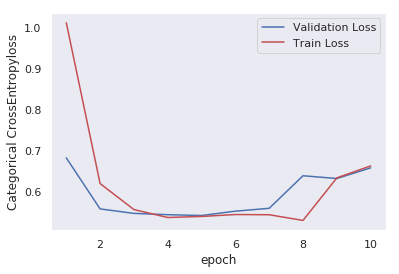

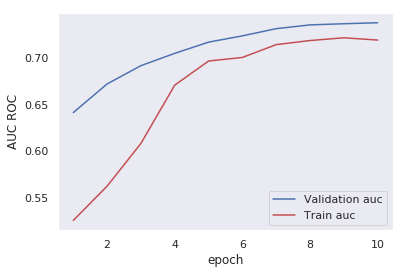

In [36]:
x = list(range(1,11))


cv_loss = history_1.history['val_loss']
t_loss = history_1.history['loss']


cv_auc = history_1.history['val_auroc']
t_auc = history_1.history['auroc']

plt_dynamic_loss(x, t_loss, cv_loss)

plt_dynamic_auc(x, t_auc, cv_auc)

#### Evaluating the model on test data

In [37]:
score = model_1.evaluate(X_test_1, y_test, verbose=1)
print('Test score:', score[0])
print('Test roc:', score[1])


21850/21850 [==============================] - 243s 11ms/step
Test score: 0.5391652995279779
Test roc: 0.7240412774486006


### Conclusions:

1) Test loss = 0.539 and Test AuRoc = 0.724

_____________________________________________________________________________

### Model2  (Similar to model1 but we integer encode text data based on tfidf values of words instead of tokenizing on whole training words)

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

#### This means we are changing the layer that deals with text data (essay)
#### Everything else we are keeping same as the previous model(model_1)

In [0]:
# Filtering Text Data based on idf values

tfidf = TfidfVectorizer()
combine_tfidf = tfidf.fit_transform(X_train["essay"])

# converting to dictionary
combine_dict = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))

In [0]:
d = {'word': tfidf.get_feature_names() , 'idf_value': tfidf.idf_}

tfidf_df = pd.DataFrame(data=d)

tfidf_df.set_index = 'idf_value'

In [36]:
tfidf_df.sort_values(by ='idf_value' , inplace=True  )

tfidf_df.set_index = 'idf_value'

tfidf_df.head(2)

,word,idf_value
40455,students,1.007724
28168,nannan,1.044886


In [37]:
print("Min tf-idf value is: ",min(tfidf_df['idf_value']))

print("Max tf-idf value is: ",max(tfidf_df['idf_value']))

Min tf-idf value is:  1.0077243743721636
Max tf-idf value is:  11.4619455276077


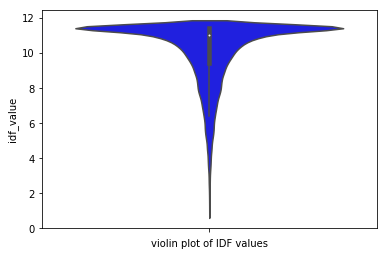

In [38]:
import seaborn as sns

fig , ax = plt.subplots()

ax = sns.violinplot(y=tfidf_df['idf_value'],color='b')
ax.set_xlabel("violin plot of IDF values")


plt.show()

In [39]:
print("Quantiles: 0-25-50-75")
print(np.percentile(tfidf_df['idf_value'],np.arange(0, 100, 25)))

print(np.percentile(tfidf_df['idf_value'] , 100))

Quantiles: 0-25-50-75
[ 1.00772437  9.44704251 11.05648042 11.46194553]
11.4619455276077


In [40]:
mask =   (tfidf_df['idf_value']>=2) & (tfidf_df['idf_value'] <=11.06)

tfidf_selected = tfidf_df[mask]

print(tfidf_selected.shape)

(28870, 2)


In [0]:
corpus_selected = tfidf_selected['word'].tolist()

In [43]:
corpus_selected[0:5]


['year', 'new', 'one', 'these', 'would']

In [44]:
from keras.preprocessing.text import Tokenizer
# Encodes from index 1 to max_vocabulary_words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus_selected)

X_train['IntegerEncoding_2']  = tokenizer.texts_to_sequences(X_train['essay'].values)
X_cv['IntegerEncoding_2']     = tokenizer.texts_to_sequences(X_cv['essay'].values)
X_test['IntegerEncoding_2']   = tokenizer.texts_to_sequences(X_test['essay'].values)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [45]:
X_train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,IntegerEncoding_1,IntegerEncoding_2
20846,la,ms,grades_prek_2,0,math_science,mathematics,my school small population big heart i want in...,376.76,"[4, 3, 81, 226, 406, 678, 2, 34, 470, 1, 19, 5...","[57, 177, 366, 610, 8, 407, 8, 1005, 2724, 117..."
81132,mi,ms,grades_prek_2,6,literacy_language math_science,literature_writing mathematics,a typical day classroom busy we jam packed mat...,298.99,"[171, 690, 20, 6, 1014, 14, 6536, 3780, 41, 84...","[589, 958, 6362, 3579, 39, 899, 10, 10, 110, 8..."


In [46]:
max_vocabulary = len(tokenizer.word_index)
print("There are {} number of unique words in the entire text corpus".format(max_vocabulary))

print(X_train['IntegerEncoding_2'].values[0])
print(len(X_train['IntegerEncoding_2'].values[0]))


There are 28870 number of unique words in the entire text corpus
[57, 177, 366, 610, 8, 407, 8, 1005, 2724, 1178, 27, 254, 2, 108, 2, 25, 80, 585, 1671, 1219, 137, 444, 905, 66, 1707, 753, 814, 177, 25, 52, 145, 62, 1122, 170, 47, 449, 1621, 25, 37, 8, 35, 80, 8, 69, 90, 50, 166, 129, 3659, 455, 214, 340, 190, 253, 1812, 771, 101, 526, 26, 129, 339, 349, 190, 340, 98, 413, 2528, 1549, 15, 7, 1229, 349, 190, 340, 14, 367, 1885, 6180, 7, 272, 23, 396, 779, 365, 1513, 277, 739, 193, 7, 1621, 52, 52, 349, 190, 66, 822, 7, 416, 190, 69, 141, 54]
102


In [0]:
# truncate and/or pad input sequences

# We will be using this as text input to our model

max_review_length = 500
text_padded_input_train = sequence.pad_sequences(X_train['IntegerEncoding_2'].values, maxlen=max_review_length , padding='post' , truncating ='post')
text_padded_input_cv    =   sequence.pad_sequences(X_cv['IntegerEncoding_2'].values, maxlen=max_review_length , padding='post' , truncating ='post')
text_padded_input_test  = sequence.pad_sequences(X_test['IntegerEncoding_2'].values, maxlen=max_review_length , padding='post' , truncating ='post')


In [69]:
print(len(text_padded_input_train[0]))
print(text_padded_input_cv[65])

500
[   24   119    42   627  1027  4395  1729   148   426   448  3540    93
  3322    66   171  4190   344   191  1819   173   179    80   213    85
   161    59   368   595   957   360    63   854  1402  1864    17    92
    29   126  1385  1188   687   937  2387   244   338    95    24   512
   790   260    56   155    56 20455    44  8199 20875  1069   260   195
   602   193   489   937  8199 20875   488   260  4183   526 20875   213
  2993  2838   147   419   456   456  4183    35  1433   652   456   101
  5714   342  3958  1802   924   858 20875  2778   526 20875   147   121
   507  2414    42   770  1680   195  2904   488   318   513  3050  5871
   148 17838   454  7420    35  1433  1854  8620   955   513  3518  6230
  1069   260    95    35 10475  1980 11518  4105     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     

In [0]:
import pickle
with open('/content/gdrive/My Drive/AppliedAI Dataset/glove_vectors', 'rb') as f:
    glove = pickle.load(f)
    glove_words =  set(glove.keys())

In [0]:
from numpy import zeros

# create a weight matrix for words in training docs
embedding_matrix = zeros((max_vocabulary+1, 300))
for word, i in tokenizer.word_index.items():
    if word in glove_words:
       embedding_vector = glove[word]
       embedding_matrix[i] = embedding_vector


In [51]:
print(embedding_matrix[1].shape)
print(embedding_matrix[1])

(300,)
[-1.4240e-01  2.3713e-01 -3.9057e-01 -7.3110e-02  3.5530e-01 -7.2130e-02
 -3.0864e+00  3.8436e-01 -2.6778e-01 -2.0027e-01  1.4898e-01  4.5742e-01
  2.1269e-01 -1.5310e-01  1.8688e-01 -1.5698e-01  6.5033e-02 -4.8631e-02
 -2.3764e-01  4.0033e-01  5.1223e-01  2.7246e-01 -3.3327e-01  7.5138e-02
 -4.7034e-01 -1.8123e-01  3.9304e-01  6.7642e-02  1.5320e-01  4.9700e-01
 -5.2482e-01  9.6122e-02 -8.3464e-02  9.4474e-02 -3.1080e-01  3.9169e-03
 -2.0585e-01  7.9736e-01  1.3143e-01 -1.7278e-01 -1.3190e-01 -1.3695e-01
  4.7299e-01  1.7741e-01 -3.1142e-01 -3.0928e-01  8.7610e-02  2.5012e-01
 -6.9745e-01  2.2594e-01  3.5158e-01  2.9656e-01  4.1315e-01  1.8174e-01
  1.3404e-01 -3.6780e-01  2.8399e-02  4.1781e-01 -1.0088e-01  3.6607e-01
 -3.0281e-01 -3.6929e-01  3.1273e-01  2.1106e-01 -5.4009e-01  2.3604e-01
  1.6610e-01  3.2307e-01 -2.6003e-02  5.4128e-02 -5.5720e-01  9.5873e-02
  3.3894e-01 -3.9044e-01  5.5129e-02 -5.4555e-01 -4.7377e-01 -7.2365e-03
 -6.4361e-03 -2.9842e-02  3.7989e-01 -1.3738

In [0]:

# text_input: meant to receive sequences of 600 integers, between 1 and max_vocabulary.
# Note that we can name any layer by passing it a "name" argument.

text_input =  Input(shape=(500,), dtype='int32', name='text_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 300 dimensional vectors.
x = Embedding(output_dim=300, input_dim=max_vocabulary+1, input_length=500 , weights=[embedding_matrix] , trainable=False)(text_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
x = LSTM(100 , return_sequences=True ,kernel_regularizer=regularizers.l2(0.001) )(x)

flatten_12= Flatten()(x)


In [183]:
# Concatinate all the flatten layers and numerical layer

print("Constructing Model2")

x_concat = concatenate([flatten_12 , flatten_2 , flatten_3 ,flatten_4 , flatten_5 , flatten_6 , num_dense])

x = Dense(100, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x_concat)

x=Dropout(0.5)(x)

x = Dense(200,activation="sigmoid",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)

x = BatchNormalization()(x)

x=Dropout(0.5)(x)

x = Dense(64,activation="sigmoid", kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)



output = Dense(2, activation='softmax', name='output')(x)

model_2 = Model(inputs=[text_input, state_input ,prefix_input,categories_input,
                        subcategories_input ,grade_input ,num_input],outputs=[output])



print(model_2.summary())

Constructing Model2
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 500, 300)     8661300     text_input[0][0]                 
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
________________________________________________________________________

In [0]:
# inputs to the model_2

X_train_2 = [text_padded_input_train, school_state_train ,teacher_prefix_train ,  clean_categories_train 
             , clean_subcategories_train , grade_train , num_feat_train]

X_cv_2 = [text_padded_input_cv, school_state_cv ,teacher_prefix_cv ,  clean_categories_cv 
             , clean_subcategories_cv , grade_cv , num_feat_cv]

X_test_2 = [text_padded_input_test, school_state_test ,teacher_prefix_test ,  clean_categories_test 
             , clean_subcategories_test , grade_test , num_feat_test]

In [189]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])
history_2 = model_2.fit(X_train_2,y_train,batch_size=2000,
                        epochs=17,validation_data=(X_cv_2,y_cv),callbacks=callbacks_1)


Train on 69918 samples, validate on 17480 samples
Epoch 1/17
69918/69918 [==============================] - 84s 1ms/step - loss: 0.6115 - auroc: 0.6446 - val_loss: 0.5682 - val_auroc: 0.7145

Epoch 00001: val_loss did not improve from 0.42461
Epoch 2/17
69918/69918 [==============================] - 83s 1ms/step - loss: 0.5429 - auroc: 0.6772 - val_loss: 0.5021 - val_auroc: 0.7290

Epoch 00002: val_loss did not improve from 0.42461
Epoch 3/17
69918/69918 [==============================] - 79s 1ms/step - loss: 0.4891 - auroc: 0.7145 - val_loss: 0.4722 - val_auroc: 0.7376

Epoch 00003: val_loss did not improve from 0.42461
Epoch 4/17
69918/69918 [==============================] - 82s 1ms/step - loss: 0.4733 - auroc: 0.7222 - val_loss: 0.4752 - val_auroc: 0.7389

Epoch 00004: val_loss did not improve from 0.42461
Epoch 5/17
69918/69918 [==============================] - 81s 1ms/step - loss: 0.4695 - auroc: 0.7278 - val_loss: 0.4726 - val_auroc: 0.7424

Epoch 00005: val_loss did not improv

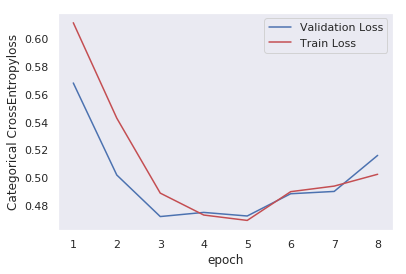

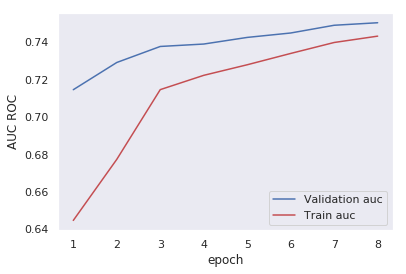

In [190]:
x = list(range(1,9))


cv_loss = history_2.history['val_loss']
t_loss = history_2.history['loss']


cv_auc = history_2.history['val_auroc']
t_auc = history_2.history['auroc']

plt_dynamic_loss(x, t_loss, cv_loss)

plt_dynamic_auc(x, t_auc, cv_auc)

#### Evaluating the model on test data

In [191]:
score = model_2.evaluate(X_test_2, y_test, verbose=1)
print('Test score:', score[0])  
print('Test roc:', score[1])


21850/21850 [==============================] - 300s 14ms/step
Test score: 0.4706692377162471
Test roc: 0.7381125102498359


#### Test lloss = 0.470 and Test AuRoc = 0.738
#### Observed a significant improvement in Loss value compared to model1(due to selecting the words based on idf values for integer encoding text data)

_________________________________________________________________________________

### Model3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png

In [0]:

from keras.layers import Conv1D
from keras.initializers import he_normal


# Input cannot be a single dimension like (7,) => # now: model.output_shape == (None, 7)
# It gives ValueError: Input 0 is incompatible with layer conv1d_3: expected ndim=3, found ndim=2
# we will reshape the input to (*,7,1)

input_without_text  = Input(shape=(7,1) , name='other_than_text') # now: model.output_shape == (None, 7 , 1)

conv = Conv1D(64 , 3 , activation='relu' ,  kernel_initializer=he_normal(seed=None) , padding='same')(input_without_text)

conv = Conv1D(32 , 3 , activation='relu' ,  kernel_initializer=he_normal(seed=None) , padding='same')(conv)

flatten_without_text = Flatten()(conv)


### Concatinating all inputs other than 'essay'

In [54]:
print(num_projects_train.shape , price_train.shape , school_state_train.reshape(-1,1).shape)

(69918, 1) (69918, 1) (69918, 1)


In [0]:

feat_train = np.concatenate((num_projects_train , price_train , school_state_train.reshape(-1,1) , teacher_prefix_train.reshape(-1,1) ,\
                             clean_categories_train.reshape(-1,1) , clean_subcategories_train.reshape(-1,1) ,\
                            grade_train.reshape(-1,1)) , axis = 1)
feat_cv = np.concatenate((num_projects_cv , price_cv , school_state_cv.reshape(-1,1) , teacher_prefix_cv.reshape(-1,1) , \
                          clean_categories_cv.reshape(-1,1) , clean_subcategories_cv.reshape(-1,1) ,\
                            grade_cv.reshape(-1,1)) , axis = 1)
feat_test = np.concatenate((num_projects_test , price_test , school_state_test.reshape(-1,1) , teacher_prefix_test.reshape(-1,1) ,\
                            clean_categories_test.reshape(-1,1) , clean_subcategories_test.reshape(-1,1) ,\
                            grade_test.reshape(-1,1)) , 
                           axis = 1)

In [56]:
# Reshaping it to the input size mentioned in 'input_without_text' layer

x_train_without_text = feat_train.reshape(-1 , 7 ,1)
x_cv_without_text =   feat_cv.reshape(-1 , 7 ,1)
x_test_without_text =  feat_test.reshape(-1 , 7 ,1)

print(x_train_without_text.shape)
print(x_train_without_text[0])

(69918, 7, 1)
[[-4.01910925e-01]
 [ 2.12962264e-01]
 [ 1.80000000e+01]
 [ 3.00000000e+00]
 [ 3.20000000e+01]
 [ 3.42000000e+02]
 [ 3.00000000e+00]]


In [0]:

from keras.layers import Conv1D
from keras.initializers import he_normal

input_without_text  = Input(shape=(7,1) , name='other_than_text')

conv = Conv1D(64 , 3 , activation='relu' ,  kernel_initializer=he_normal(seed=None) , padding='same')(input_without_text)

conv = Conv1D(32 , 3 , activation='relu' ,  kernel_initializer=he_normal(seed=None) , padding='same')(conv)

flatten_without_text = Flatten()(conv)


In [58]:
# Concatinate all the text flattened layer and without_text flattened layer

print("Constructing Model3")

x_concat = concatenate([flatten_12 , flatten_without_text])

x = Dense(100, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x_concat)

x=Dropout(0.5)(x)

x = Dense(200,activation="sigmoid",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)

x = BatchNormalization()(x)

x=Dropout(0.5)(x)

x = Dense(64,activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)



output = Dense(2, activation='softmax', name='output')(x)

model_3 = Model(inputs=[text_input, input_without_text],outputs=[output])



print(model_3.summary())

Constructing Model3
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 500)          0                                            
__________________________________________________________________________________________________
other_than_text (InputLayer)    (None, 7, 1)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 500, 300)     8661300     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 7, 64)        256

In [198]:
tbc= TensorBoardColab(startup_waiting_time=30)

Wait for 30 seconds...
TensorBoard link:
https://1eabe40d.ngrok.io


In [0]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])


In [72]:
history_3 = model_3.fit([text_padded_input_train , x_train_without_text ],y_train, batch_size=512 ,
                        epochs=25,validation_data=([text_padded_input_cv , x_cv_without_text ],y_cv),callbacks=callbacks_1)

Train on 69918 samples, validate on 17480 samples
Epoch 1/25
69918/69918 [==============================] - 171s 2ms/step - loss: 0.4340 - auroc: 0.5095 - val_loss: 0.4314 - val_auroc: 0.5224

Epoch 00001: val_loss improved from 0.43359 to 0.43141, saving model to model_1.h5
Epoch 2/25
69918/69918 [==============================] - 178s 3ms/step - loss: 0.4315 - auroc: 0.5104 - val_loss: 0.4322 - val_auroc: 0.5127

Epoch 00002: val_loss did not improve from 0.43141
Epoch 3/25
69918/69918 [==============================] - 174s 2ms/step - loss: 0.4303 - auroc: 0.5158 - val_loss: 0.4299 - val_auroc: 0.5073

Epoch 00003: val_loss improved from 0.43141 to 0.42988, saving model to model_1.h5
Epoch 4/25
69918/69918 [==============================] - 177s 3ms/step - loss: 0.4296 - auroc: 0.5104 - val_loss: 0.4290 - val_auroc: 0.5126

Epoch 00004: val_loss improved from 0.42988 to 0.42897, saving model to model_1.h5
Epoch 5/25
69918/69918 [==============================] - 175s 3ms/step - loss

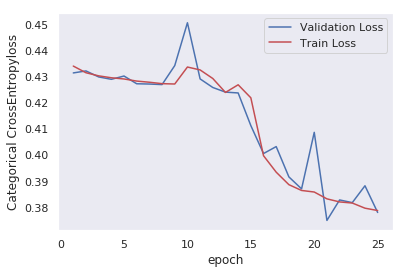

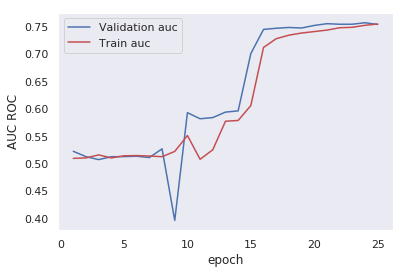

In [74]:
x = list(range(1,26))


cv_loss = history_3.history['val_loss']
t_loss = history_3.history['loss']


cv_auc = history_3.history['val_auroc']
t_auc = history_3.history['auroc']

plt_dynamic_loss(x, t_loss, cv_loss)

plt_dynamic_auc(x, t_auc, cv_auc)

#### Evaluating the model on test data

In [75]:
score = model_3.evaluate([text_padded_input_test , x_test_without_text ], y_test, verbose=1)
print('Test score:', score[0])
print('Test roc:', score[1])

21850/21850 [==============================] - 306s 14ms/step
Test score: 0.3745377472663635
Test roc: 0.76383592558743


#### Test loss = 0.374 and Test AUC=0.763
#### Significant improvemet observer with loss and AUC values compared to other architectures
#### (Note: For text data , used the same approach as we used for Model2)

_________________________________________________________________________________

### Conclusions:

1) Used 2 Different NN architectures with LSTM to analyse DonorsChoose.org dataset

2) LSTM are good to have  when we have lots of text data to analize

3) Model3 Produced best results compared to other models that we have implemented


In [40]:


from prettytable import PrettyTable

x= PrettyTable()

x.field_names = ["Model"," MultiClass Log Loss "," AUC "]
x.add_row([" Model 1", 0.539 , 0.724])
x.add_row([" Model 2", 0.470,  0.738])
x.add_row([" Model 3", 0.374 , 0.763])



print(x)

+----------+-----------------------+-------+
|  Model   |  MultiClass Log Loss  |  AUC  |
+----------+-----------------------+-------+
|  Model 1 |         0.539         | 0.724 |
|  Model 2 |          0.47         | 0.738 |
|  Model 3 |         0.374         | 0.763 |
+----------+-----------------------+-------+
